In [1]:
%matplotlib inline
import sys
from os.path import exists

# this is the repository I pulled/downloaded from github: 
CONGA_PATH = '/Users/ceglian/Codebase/conga/'
# confirm that it's the right level directory (since the repo and library have the same name)
assert exists(CONGA_PATH+'/README.md')
sys.path.append(CONGA_PATH)

import scanpy as sc
import conga
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# top 50 TCRdist kPCS 
gex_datafile = '/Users/ceglian/Downloads/conga_example_datasets_v1/vdj_v1_hs_pbmc3_5gex_filtered_gene_bc_matrices_h5.h5'
gex_datatype = '10x_h5' # other possibilities right now: ['10x_mtx', 'h5ad'] (h5ad from scanpy)
tcr_datafile = '/Users/ceglian/Downloads/conga_example_datasets_v1/vdj_v1_hs_pbmc3_t_filtered_contig_annotations.csv'
organism = 'human'

clones_file = 'tmp_hs_pbmc_clones.tsv'
outfile_prefix = 'tmp_hs_pbmc' # this string will be prepended to results (figure and table) filenames

assert exists(gex_datafile)
assert exists(tcr_datafile)
# this creates the TCRdist 'clones file'
conga.tcrdist.make_10x_clones_file.make_10x_clones_file( tcr_datafile, organism, clones_file )

# this command will create another file with the kernel PCs for subsequent reading by conga
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file( clones_file, organism )
adata = conga.preprocess.read_dataset(gex_datafile, gex_datatype, clones_file )

# store the organism info in adata
adata.uns['organism'] = organism

adata
adata.obsm['X_pca_tcr'].shape

ab_counts: []
old_unpaired_barcodes: 0 old_paired_barcodes: 0 new_stringent_paired_barcodes: 0 paired_barcode_fraction: 1.0
compute tcrdist distance matrix for 0 clonotypes
Using Python TCRdist calculator. Consider compiling C++ calculator for faster perfomance.


ValueError: zero-size array to reduction operation maximum which has no identity

In [6]:
# CDR3-alpha regions:
adata.obs['cdr3a'].head(3)

AAACCTGAGATCTGAA-1    CAASIGPLGTGTASKLTF
AAACCTGAGGAACTGC-1          CAASDNTDKLIF
AAACCTGAGGAGTCTG-1      CAVEANNAGNNRKLIW
Name: cdr3a, dtype: object

In [7]:
adata = conga.preprocess.filter_and_scale( 
    adata, 
    min_genes_per_cell=200,
    max_genes_per_cell=2500,
    max_percent_mito=0.1,
)

filtered out 80 cells with more than 2500 genes
filtered out 26 cells with more than 0.1 percent mito
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 14939)]
num antibody features: 0
excluding 94 TR genes (89 variable)
excluding 1 sexlinked genes
total of 1022 variable genes (3070, 14939)
Normalize and logging matrix...
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 1022)]
feature_types counter: [('Gene Expression', 14939)]
normalize_and_log_the_raw_matrix: adata.raw.X.max()=  588.0


In [8]:
adata = conga.preprocess.reduce_to_single_cell_per_clone(adata)

adata

compute pca to find rep cell for each clone (3070, 1022)
num_clones: 2896
normalize_and_log_the_raw_matrix:: matrix is already logged
choose representative cell for clone: 0 2896 (3070, 1022)
choose representative cell for clone: 1000 2896 (3070, 1022)
choose representative cell for clone: 2000 2896 (3070, 1022)
reduce from 3070 cells to 2896 cells (one per clonotype)


AnnData object with n_obs × n_vars = 2896 × 1022
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'gex_variation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'conga_results', 'conga_stats', 'organism', 'log1p', 'hvg', 'raw_matrix_is_logged', 'pca'
    obsm: 'X_pca_tcr'
    varm: 'PCs'
    layers: 'scaled'

In [9]:
adata = conga.preprocess.cluster_and_tsne_and_umap( adata )

computing X_pca_gex using sc.tl.pca


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/uma

running 1D UMAP gex
ran louvain clustering: louvain_gex
running 1D UMAP tcr
ran louvain clustering: louvain_tcr


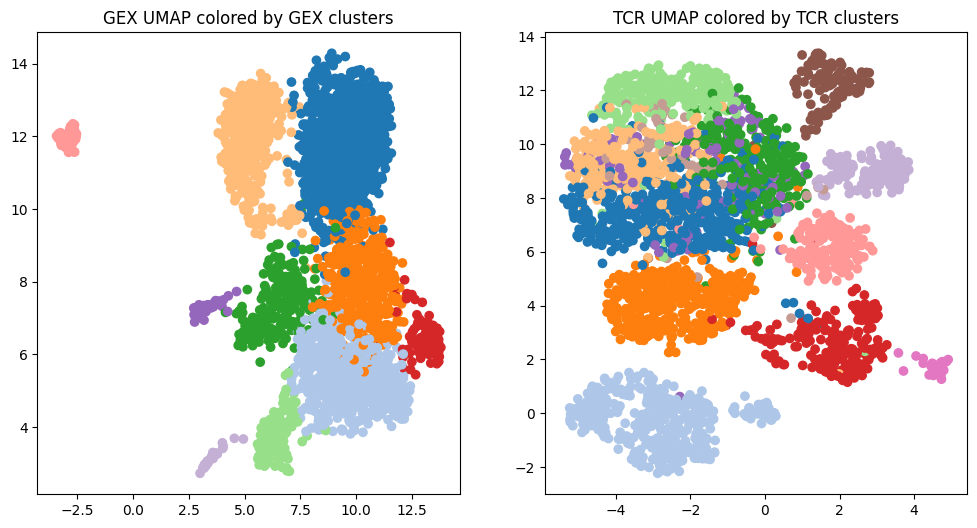

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
clusters = np.array(adata.obs['clusters_gex'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x%20] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('GEX UMAP colored by GEX clusters')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
clusters = np.array(adata.obs['clusters_tcr'])
cmap = plt.get_cmap('tab20')
colors = [ cmap.colors[x%20] for x in clusters]
plt.scatter( xy[:,0], xy[:,1], c=colors)
plt.title('TCR UMAP colored by TCR clusters');

In [11]:
# these are the nbrhood sizes, as a fraction of the entire dataset:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists)

# stash these in obs array, they are used in a few places...
adata.obs['nndists_gex'] = nndists_gex
adata.obs['nndists_tcr'] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata) #stores in adata.uns

compute D gex 2896
argpartitions: 0.01 2896 gex
calculate nndists: gex 0.01
DONE calculating nndists: gex 0.01
argpartitions: 0.1 2896 gex
compute D tcr 2896
argpartitions: 0.01 2896 tcr
calculate nndists: tcr 0.01
DONE calculating nndists: tcr 0.01
argpartitions: 0.1 2896 tcr
setup_tcr_cluster_names: ['0', '1_AV14++', '2_av8', '3', '4_bv6', '5_AV12', '6_BV20', '7_av26', '8', '9_AV9', '10_AV1', '11', '12_AV1']


In [12]:
results = conga.correlations.run_graph_vs_graph(
    adata, all_nbrs, outfile_prefix=outfile_prefix)

results.head()

find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
saved graph_vs_graph results to tsvfile: tmp_hs_pbmc_graph_vs_graph.tsv


conga_score  num_neighbors_gex  num_neighbors_tcr  overlap  \
407  8.185392e-49                NaN              289.0       99   
391  2.161103e-48                NaN              289.0      103   
367  1.688516e-47                NaN              289.0      103   
376  1.688516e-47                NaN              289.0      103   
431  2.707687e-46                NaN              289.0       94   

     overlap_corrected  mait_fraction  clone_index  nbr_frac  \
407                 67       0.909091          107       0.1   
391                 67       0.902913           89       0.1   
367                 66       0.912621           65       0.1   
376                 66       0.922330           74       0.1   
431                 66       0.904255          132       0.1   

         graph_overlap_type  cluster_size  gex_cluster  tcr_cluster  \
407  gex_cluster_vs_tcr_nbr         126.0            5           10   
391  gex_cluster_vs_tcr_nbr         132.0            5           10   
367  gex_cluster_vs_tcr_nbr         132.0            5           10   
376  gex_cluster_vs_tcr_nbr         132.0            5           10   
431  gex_cluster_vs_tcr_nbr         123.0            5           10   

             va         ja         cdr3a           vb          jb  \
407  TRAV1-2*01  TRAJ33*01  CAVMDSNYQLIW   TRBV6-4*01  TRBJ2-5*01   
391  TRAV1-2*01  TRAJ33*01  CAVKESNYQLIW   TRBV6-2*01  TRBJ2-5*01   
367  TRAV1-2*01  TRAJ33*01  CAARDSNYQLIW    TRBV15*01  TRBJ2-3*01   
376  TRAV1-2*01  TRAJ33*01  CASFDSNYQLIW  TRBV12-5*01  TRBJ2-5*01   
431  TRAV1-2*01  TRAJ33*01  CAVRDSNYQLIW   TRBV6-4*01  TRBJ2-3*01   

                cdr3b  
407   CASSEKTGGQETQYF  
391   CASSYTEQGSETQYF  
367  CATSMGQSASTDTQYF  
376   CASGLGQGDVETQYF  
431   CASSSSGGATDTQYF

In [13]:
adata.uns['conga_results'].keys()

dict_keys(['graph_vs_graph', 'graph_vs_graph_help'])

In [14]:
# another way of getting the graph-vs-graph results DataFrame:
# conga.tags.GRAPH_VS_GRAPH = 'graph_vs_graph'
results = adata.uns['conga_results'][conga.tags.GRAPH_VS_GRAPH]
results.head() 

conga_score  num_neighbors_gex  num_neighbors_tcr  overlap  \
407  8.185392e-49                NaN              289.0       99   
391  2.161103e-48                NaN              289.0      103   
367  1.688516e-47                NaN              289.0      103   
376  1.688516e-47                NaN              289.0      103   
431  2.707687e-46                NaN              289.0       94   

     overlap_corrected  mait_fraction  clone_index  nbr_frac  \
407                 67       0.909091          107       0.1   
391                 67       0.902913           89       0.1   
367                 66       0.912621           65       0.1   
376                 66       0.922330           74       0.1   
431                 66       0.904255          132       0.1   

         graph_overlap_type  cluster_size  gex_cluster  tcr_cluster  \
407  gex_cluster_vs_tcr_nbr         126.0            5           10   
391  gex_cluster_vs_tcr_nbr         132.0            5           10   
367  gex_cluster_vs_tcr_nbr         132.0            5           10   
376  gex_cluster_vs_tcr_nbr         132.0            5           10   
431  gex_cluster_vs_tcr_nbr         123.0            5           10   

             va         ja         cdr3a           vb          jb  \
407  TRAV1-2*01  TRAJ33*01  CAVMDSNYQLIW   TRBV6-4*01  TRBJ2-5*01   
391  TRAV1-2*01  TRAJ33*01  CAVKESNYQLIW   TRBV6-2*01  TRBJ2-5*01   
367  TRAV1-2*01  TRAJ33*01  CAARDSNYQLIW    TRBV15*01  TRBJ2-3*01   
376  TRAV1-2*01  TRAJ33*01  CASFDSNYQLIW  TRBV12-5*01  TRBJ2-5*01   
431  TRAV1-2*01  TRAJ33*01  CAVRDSNYQLIW   TRBV6-4*01  TRBJ2-3*01   

                cdr3b  
407   CASSEKTGGQETQYF  
391   CASSYTEQGSETQYF  
367  CATSMGQSASTDTQYF  
376   CASGLGQGDVETQYF  
431   CASSSSGGATDTQYF

In [15]:
print(adata.uns['conga_results']['graph_vs_graph_help'])

Graph vs graph analysis looks for correlation between GEX and TCR space
by finding statistically significant overlap between two similarity graphs,
one defined by GEX similarity and one by TCR sequence similarity.

Overlap is defined one node (clonotype) at a time by looking for overlap
between that node's neighbors in the GEX graph and its neighbors in the
TCR graph. The null model is that the two neighbor sets are chosen
independently at random.

CoNGA looks at two kinds of graphs: K nearest neighbor (KNN) graphs, where
K = neighborhood size is specified as a fraction of the number of
clonotypes (defaults for K are 0.01 and 0.1), and cluster graphs, where
each clonotype is connected to all the other clonotypes in the same
(GEX or TCR) cluster. Overlaps are computed 3 ways (GEX KNN vs TCR KNN,
GEX KNN vs TCR cluster, and GEX cluster vs TCR KNN), for each of the
K values (called nbr_fracs short for neighbor fractions).

Columns (depend slightly on whether hit is KNN v KNN or KNN v clus

In [16]:
adata.uns['conga_stats']


{'num_cells_w_gex': 7231,
 'num_features_start': 33538,
 'num_cells_w_tcr': 3176,
 'min_genes_per_cell': 200,
 'max_genes_per_cell': 2500,
 'max_percent_mito': 0.1,
 'num_filt_max_genes_per_cell': 80,
 'num_filt_max_percent_mito': 26,
 'num_antibody_features': 0,
 'num_TR_genes': 94,
 'num_TR_genes_in_hvg_set': 89,
 'num_highly_variable_genes': 1022,
 'num_cells_after_filtering': 3070,
 'num_clonotypes': 2896,
 'max_clonotype_size': 29,
 'num_singleton_clonotypes': 2808}

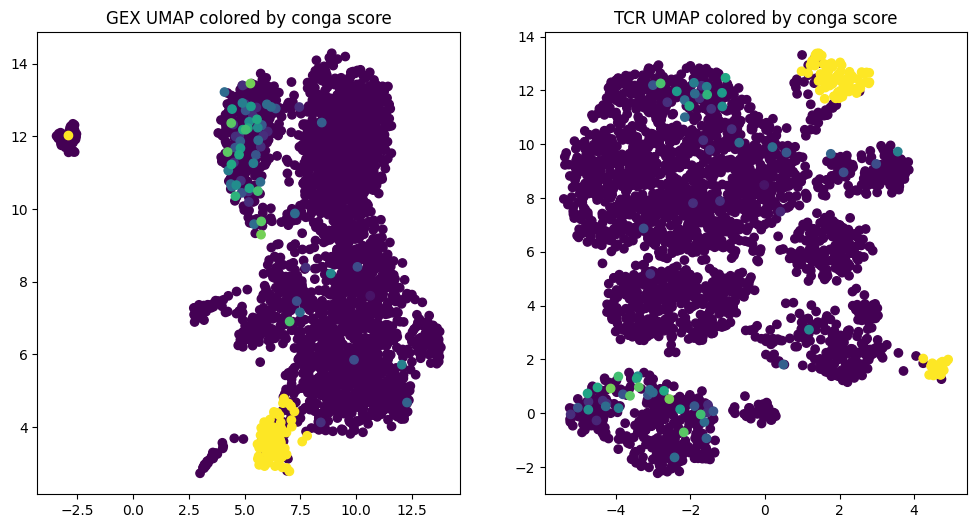

In [17]:
#put the conga hits on top
conga_scores = adata.obs['conga_scores']
colors = np.sqrt(np.maximum(-1*np.log10(conga_scores),0.0))
reorder = np.argsort(colors)

plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('GEX UMAP colored by conga score')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('TCR UMAP colored by conga score');

making tcr score table, #features= 35
run rank_genes_groups [('none', 2754), ('clp_5_10', 76), ('clp_3_1', 32), ('clp_5_12', 21), ('clp_3_5', 13)]
making cluster logos: 0 4 tmp_hs_pbmc_graph_vs_graph_logos.png
making cluster logos: 1 4 tmp_hs_pbmc_graph_vs_graph_logos.png
making cluster logos: 2 4 tmp_hs_pbmc_graph_vs_graph_logos.png
making cluster logos: 3 4 tmp_hs_pbmc_graph_vs_graph_logos.png
making: tmp_hs_pbmc_graph_vs_graph_logos.png
writing help message to file: tmp_hs_pbmc_graph_vs_graph_logos.png_README.txt


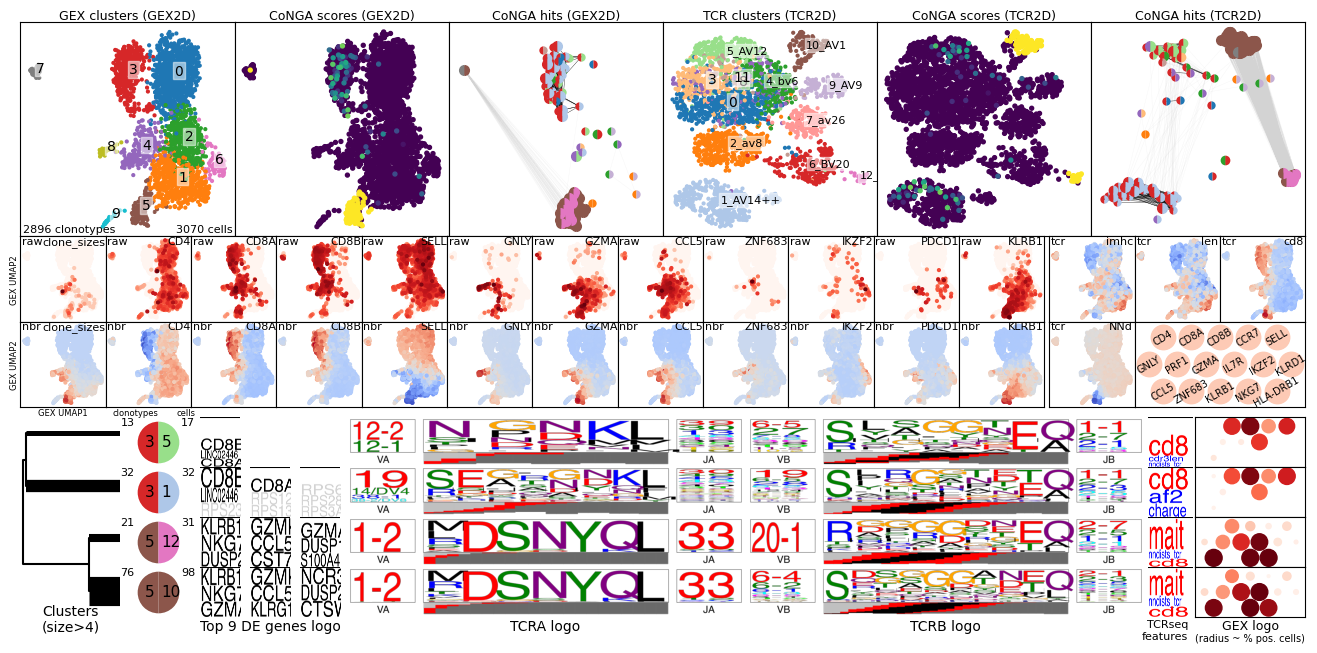

In [18]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

conga.plotting.make_graph_vs_graph_logos(
    adata,
    outfile_prefix,
    min_cluster_size,
    nbrs_gex,
    nbrs_tcr,
)



This figure summarizes the results of a CoNGA analysis that produces
scores (CoNGA) and clusters. At the top are six
2D UMAP projections of clonotypes in the dataset based on GEX similarity
(top left three panels) and TCR similarity (top right three panels),
colored from left to right by GEX cluster assignment;
CoNGA score; joint GEX:TCR cluster assignment for
clonotypes with significant CoNGA scores,
using a bicolored disk whose left half indicates GEX cluster and whose right
half indicates TCR cluster; TCR cluster; CoNGA; GEX:TCR cluster
assignments for CoNGA hits, as in the third panel.

Below are two rows of GEX landscape plots colored by (first row, left)
expression of selected marker genes, (second row, left) Z-score normalized and
GEX-neighborhood averaged expression of the same marker genes, and
(both rows, right) TCR sequence features (see CoNGA manuscript Table S3 for
TCR feature descriptions).

GEX and TCR sequence features of CoNGA hits in clusters with
5 or more hits are 

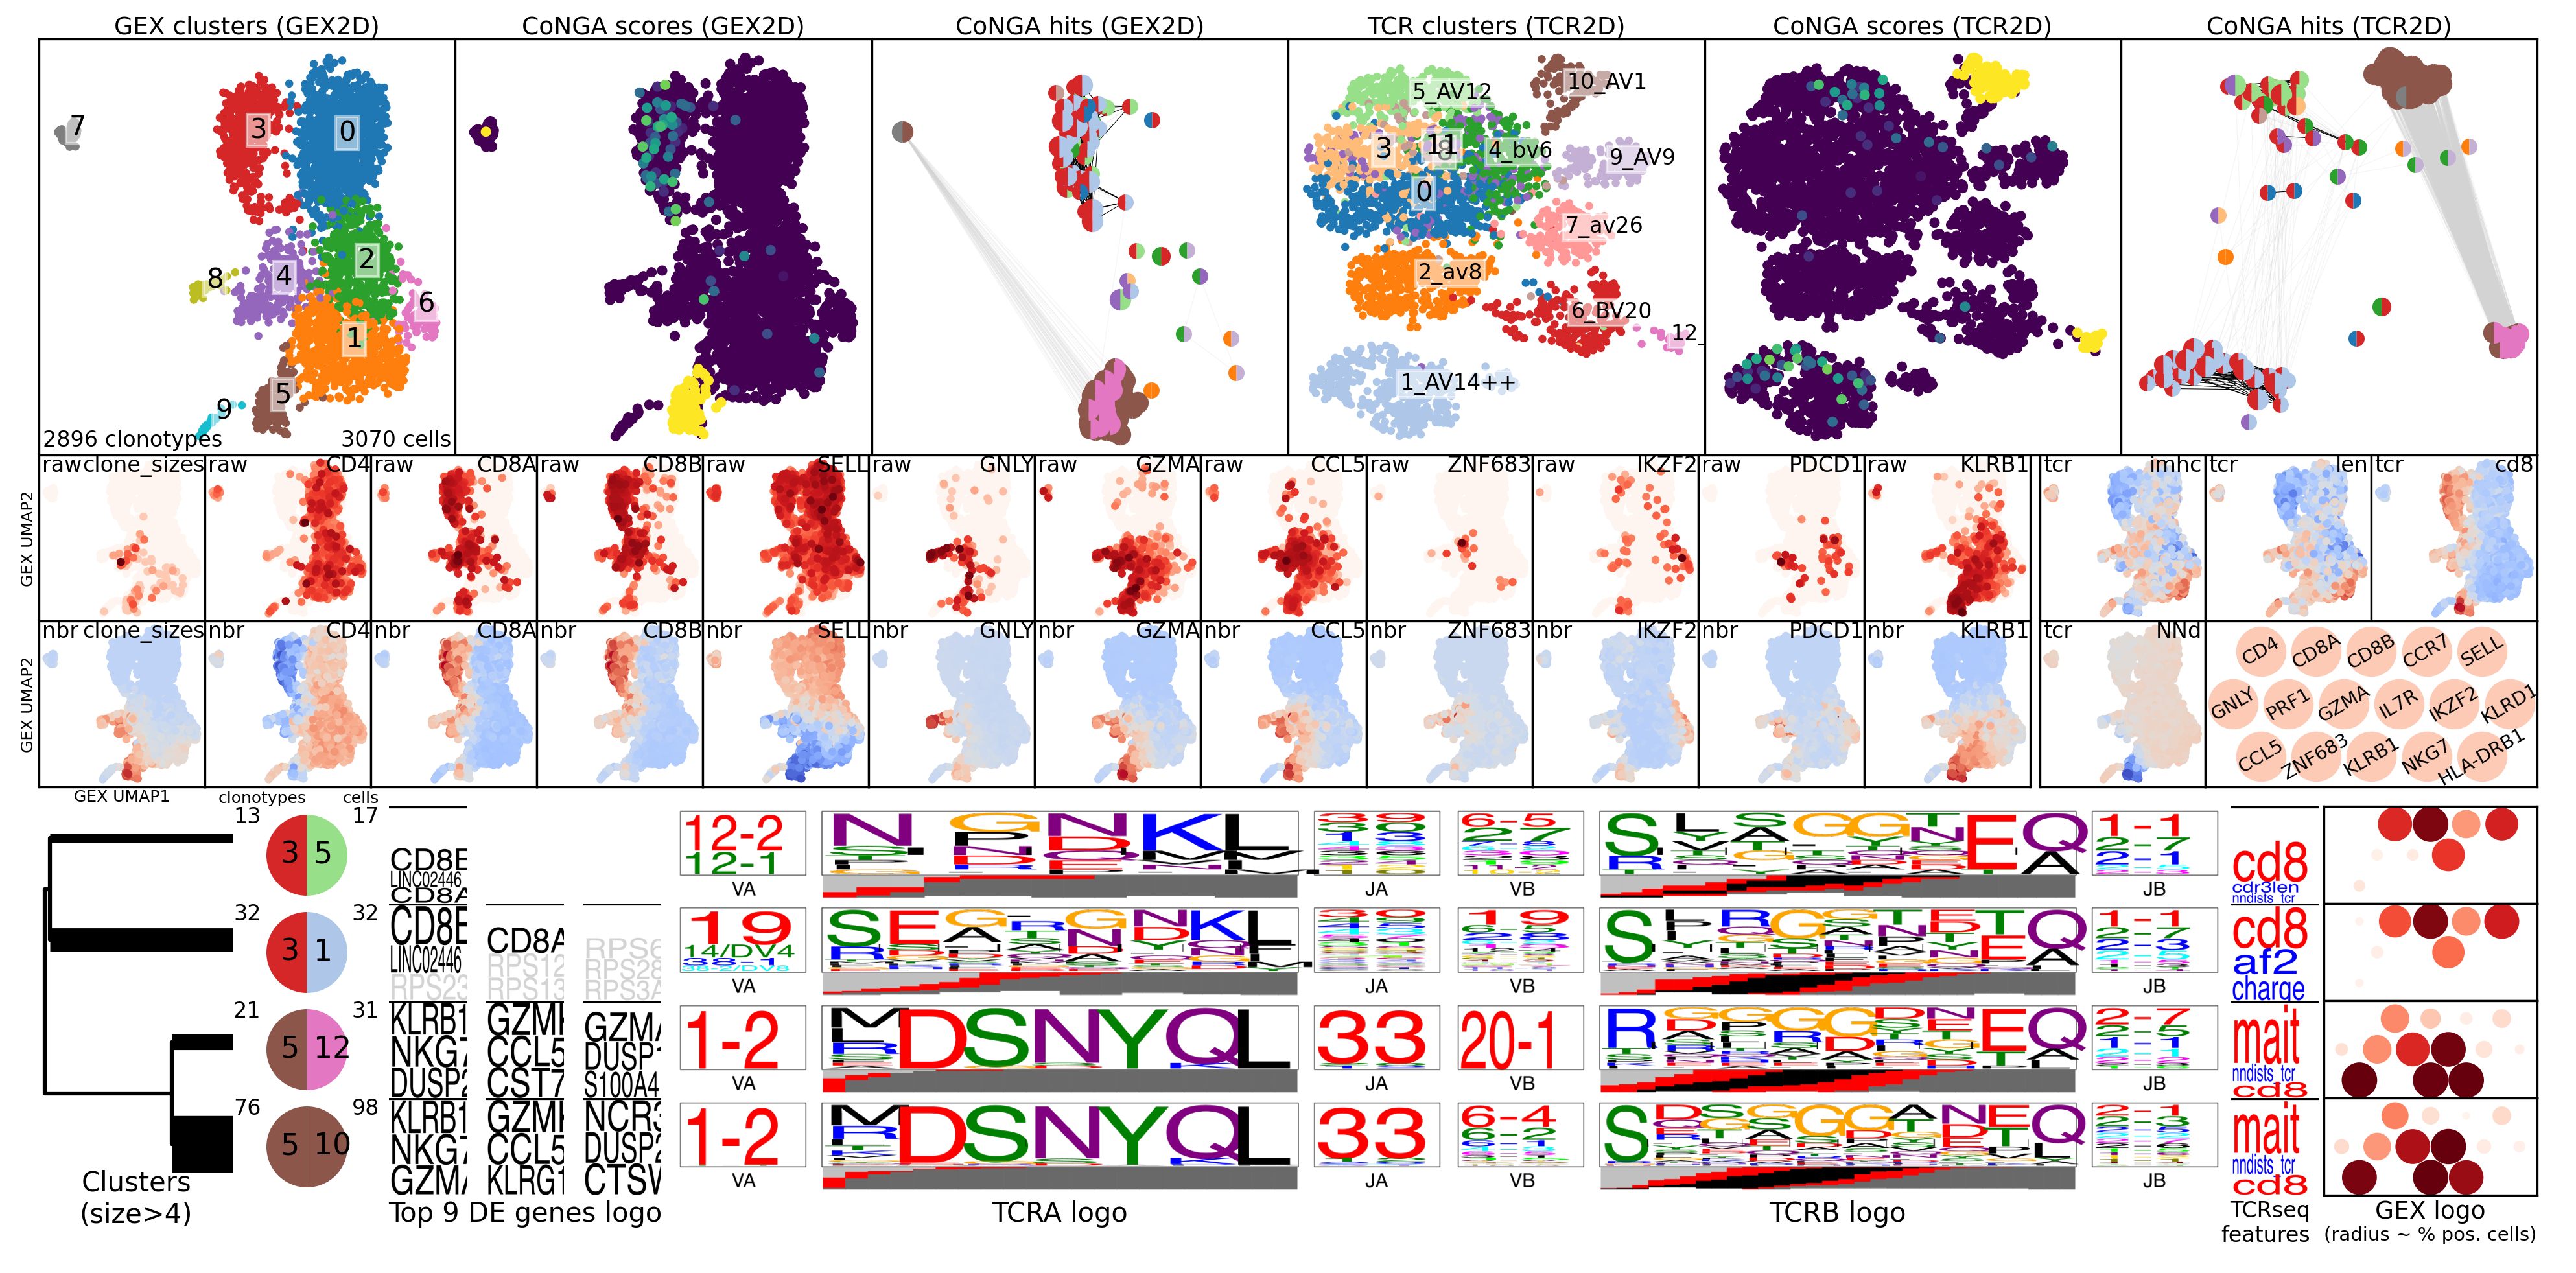

In [19]:
from PIL import Image               # for looking at some of 
from IPython.display import display # the output images.

tag = conga.tags.GRAPH_VS_GRAPH_LOGOS
pngfile = adata.uns['conga_results'].get(tag,None)
if pngfile is None:
    print('no graph-vs-graph clusters of sufficient size found')
else:
    help_message = adata.uns['conga_results'][tag+'_help']

    print(help_message)
    image = Image.open(pngfile)
    display(image)

In [20]:
conga.correlations.run_graph_vs_features(
    adata, all_nbrs, outfile_prefix=outfile_prefix)

making tcr score table, #features= 181
making tcr score table, #features= 181
making tcr score table, #features= 181
saved tcr_graph_vs_gex_features results to tsvfile: tmp_hs_pbmc_tcr_graph_vs_gex_features.tsv
saved tcr_genes_vs_gex_features results to tsvfile: tmp_hs_pbmc_tcr_genes_vs_gex_features.tsv
saved gex_graph_vs_tcr_features results to tsvfile: tmp_hs_pbmc_gex_graph_vs_tcr_features.tsv


fastcluster is not available. Consider installing for faster performance.
computing pairwise X_pca_gex distances, (2896, 40)
computing linkage matrix from pairwise X_pca_gex distances
making clustermap; num_features= 80


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


making: tmp_hs_pbmc_graph_vs_features_gex_clustermap.png
writing help message to file: tmp_hs_pbmc_graph_vs_features_gex_clustermap.png_README.txt
fastcluster is not available. Consider installing for faster performance.
computing pairwise X_pca_tcr distances, (2896, 50)
computing linkage matrix from pairwise X_pca_tcr distances
making clustermap; num_features= 80


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


making: tmp_hs_pbmc_graph_vs_features_tcr_clustermap.png
writing help message to file: tmp_hs_pbmc_graph_vs_features_tcr_clustermap.png_README.txt
making: tmp_hs_pbmc_tcr_graph_vs_gex_features_plot.png
writing help message to file: tmp_hs_pbmc_tcr_graph_vs_gex_features_plot.png_README.txt
making: tmp_hs_pbmc_tcr_graph_vs_gex_features_panels.png
writing help message to file: tmp_hs_pbmc_tcr_graph_vs_gex_features_panels.png_README.txt
making: tmp_hs_pbmc_tcr_genes_vs_gex_features_panels.png
writing help message to file: tmp_hs_pbmc_tcr_genes_vs_gex_features_panels.png_README.txt
making: tmp_hs_pbmc_gex_graph_vs_tcr_features_plot.png
writing help message to file: tmp_hs_pbmc_gex_graph_vs_tcr_features_plot.png_README.txt
making: tmp_hs_pbmc_gex_graph_vs_tcr_features_panels.png
writing help message to file: tmp_hs_pbmc_gex_graph_vs_tcr_features_panels.png_README.txt


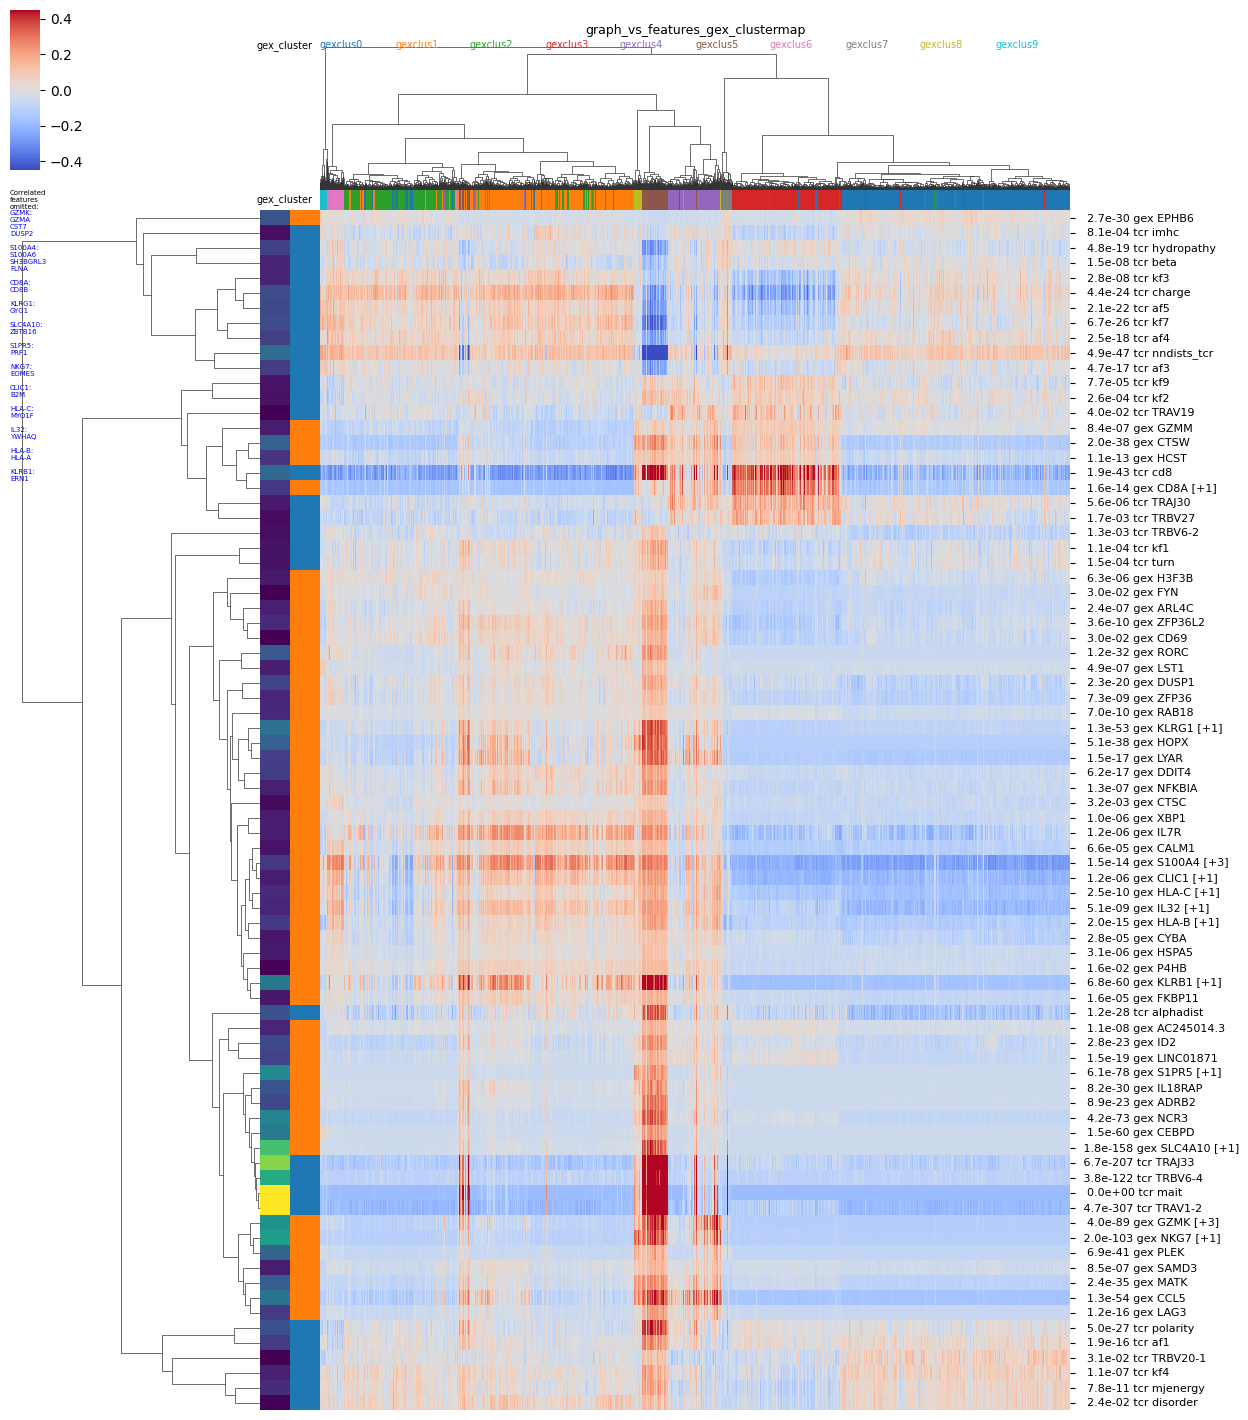

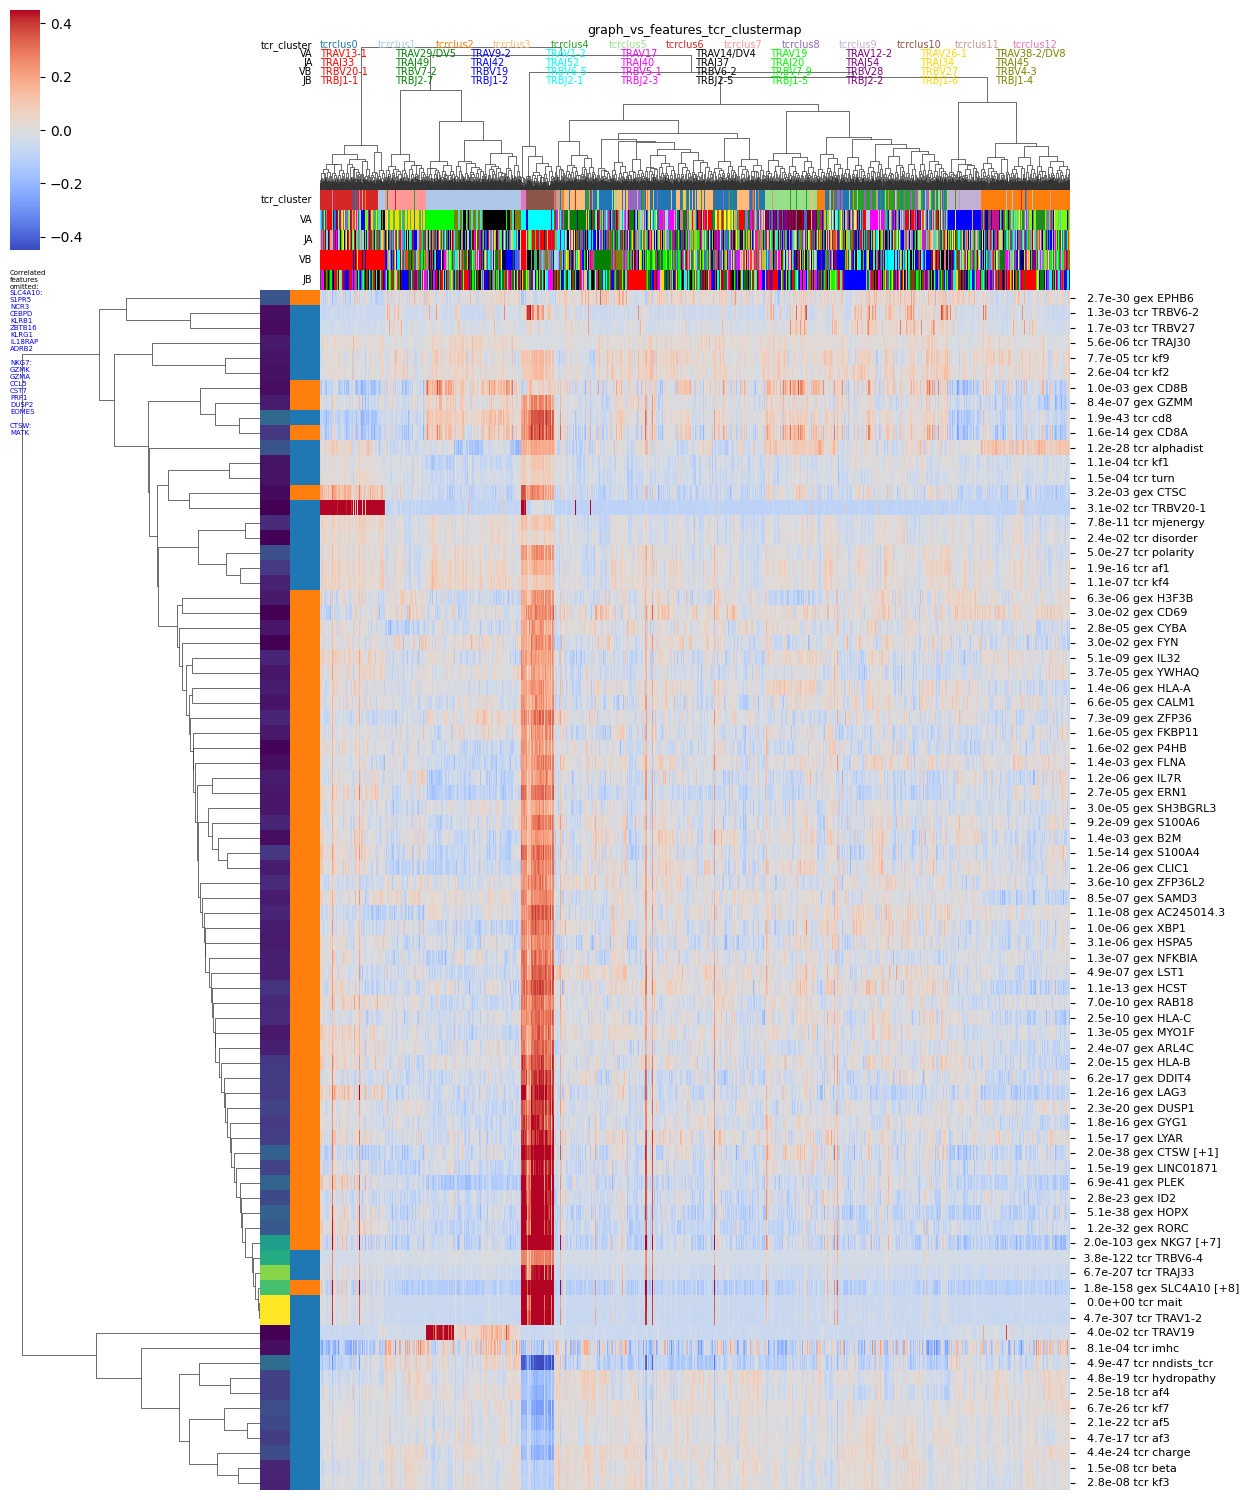

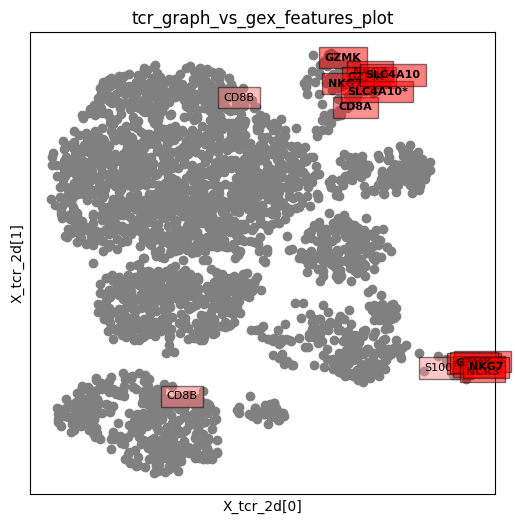

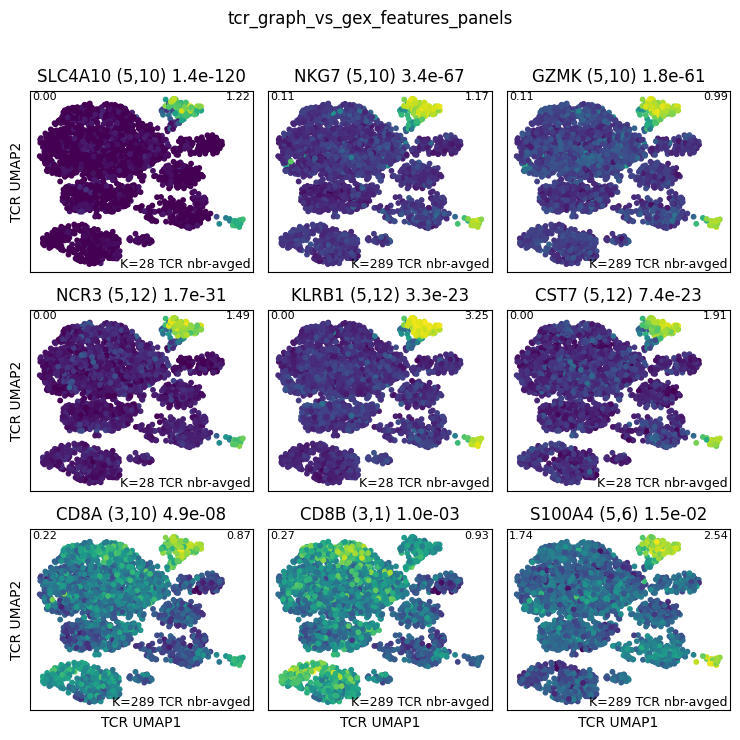

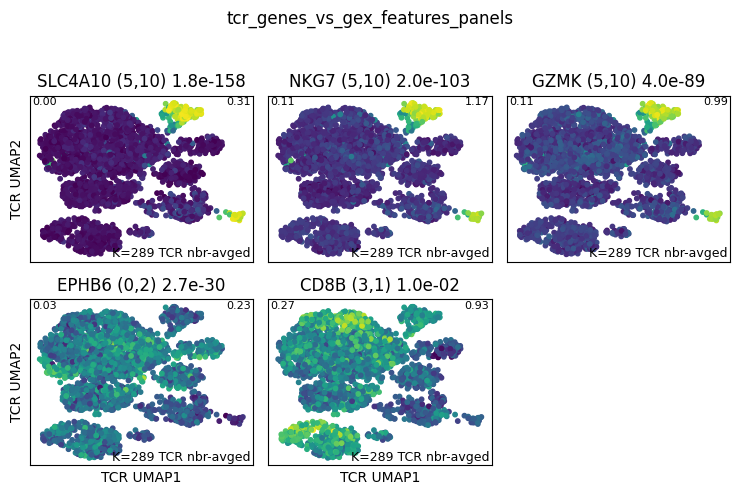

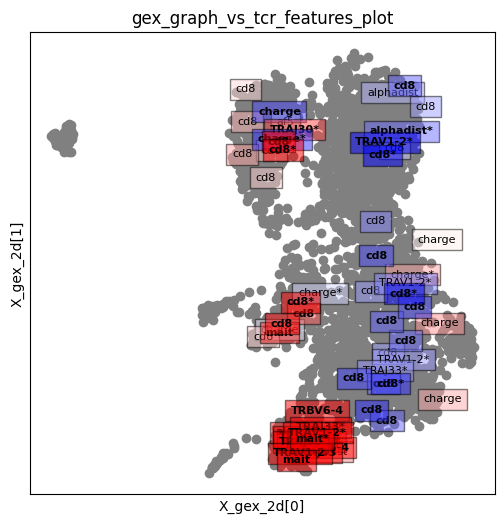

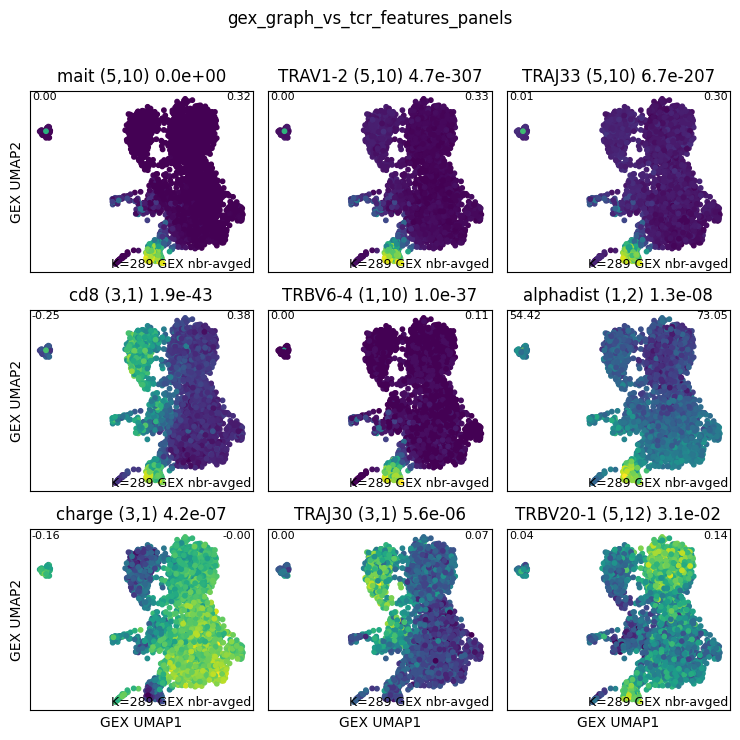

In [21]:
conga.plotting.make_graph_vs_features_plots(
    adata, all_nbrs, outfile_prefix)

In [22]:
match_results = conga.tcr_clumping.match_adata_tcrs_to_db_tcrs(
    adata, num_random_samples_for_bg_freqs=50000)

match_results.head()

tcr_clumping.match_adata_tcrs_to_db_tcrs: Matching to default literature TCR database; for more info see conga/data/new_paired_tcr_db_for_matching_nr_README.txt
Matching to paired tcrs in /Users/ceglian/Codebase/conga/conga/data/new_paired_tcr_db_for_matching_nr.tsv
num_comparisons: 11943104 2896 4124
conga.tcr_clumping.estimate_background_tcrdist_distributions:: need to compile the C++ tcrdist executables


SystemExit: 1

/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3556: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [23]:
adata

AnnData object with n_obs × n_vars = 2896 × 1022
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'gex_variation', 'louvain_gex', 'clusters_gex', 'louvain_tcr', 'clusters_tcr', 'nndists_gex', 'nndists_tcr', 'is_invariant', 'conga_scores', 'conga_fdr_values'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'conga_results', 'conga_stats', 'organism', 'log1p', 'hvg', 'raw_matrix_is_logged', 'pca', 'neighbors', 'umap', 'louvain', 'clusters_tcr_names', 'rank_genes_good_biclusters'
    obsm: 'X_pca_tcr', 'X_pca_gex', 'X_umap_gex', 'X_gex_1d', 'X_gex_2d', 'X_umap_tcr', 'X_tcr_1d', 'X_tcr_2d'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

In [ ]:
results = conga.tcr_clumping.assess_tcr_clumping(
    adata,
    outfile_prefix= outfile_prefix, # will save results as .tsv file
)

results.head()

In [ ]:
nbrs_gex, nbrs_tcr = all_nbrs[ max(nbr_fracs) ]

# now call plotting function, after results are stashed in adata
conga.plotting.make_tcr_clumping_plots(
    adata,
    nbrs_gex,
    nbrs_tcr,
    outfile_prefix,
    )

In [ ]:
results = conga.correlations.find_hotspots_wrapper(
    adata, all_nbrs, nbr_fracs = [0.1], outfile_prefix=outfile_prefix)

results.head(10)

In [ ]:
conga.plotting.make_hotspot_plots(
    adata, all_nbrs, outfile_prefix,
    )

In [28]:
# top 50 TCRdist kPCS 
gex_datafile = '/Users/ceglian/Downloads/conga_example_datasets_v1/vdj_v1_hs_pbmc3_5gex_filtered_gene_bc_matrices_h5.h5'
gex_datatype = '10x_h5' # other possibilities right now: ['10x_mtx', 'h5ad'] (h5ad from scanpy)
tcr_datafile = '/Users/ceglian/Downloads/conga_example_datasets_v1/vdj_v1_hs_pbmc3_t_filtered_contig_annotations.csv'
organism = 'human'

clones_file = 'tmp_hs_pbmc_clones.tsv'
outfile_prefix = 'tmp_hs_pbmc' # this string will be prepended to results (figure and table) filenames

assert exists(gex_datafile)
assert exists(tcr_datafile)
# this creates the TCRdist 'clones file'
conga.tcrdist.make_10x_clones_file.make_10x_clones_file( tcr_datafile, organism, clones_file )

# this command will create another file with the kernel PCs for subsequent reading by conga
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file( clones_file, organism )
rdata = conga.preprocess.read_dataset(gex_datafile, gex_datatype, clones_file )

# store the organism info in adata
rdata.uns['organism'] = organism

rdata
rdata.obsm['X_pca_tcr'].shape

ab_counts: [((1, 1), 2909), ((2, 1), 281), ((1, 2), 101), ((2, 2), 65)]
old_unpaired_barcodes: 569 old_paired_barcodes: 3356 new_stringent_paired_barcodes: 3190 paired_barcode_fraction: 0.9505363528009535
compute tcrdist distance matrix for 3000 clonotypes
Using Python TCRdist calculator. Consider compiling C++ calculator for faster perfomance.
running KernelPCA with None kernel distance matrix shape= (3000, 3000) D.max()= 502.0 force_Dmax= None
writing TCRdist kernel PCs to outfile: tmp_hs_pbmc_clones_AB.dist_50_kpcs
reading: /Users/ceglian/Downloads/conga_example_datasets_v1/vdj_v1_hs_pbmc3_5gex_filtered_gene_bc_matrices_h5.h5 of type 10x_h5
total barcodes: 7231 (7231, 33538)
reading: tmp_hs_pbmc_clones.tsv
reading: tmp_hs_pbmc_clones_AB.dist_50_kpcs
Reducing to the 3176 barcodes (out of 7231) with paired TCR sequence data


/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3176, 50)

In [33]:
adata.obs

va         ja              cdr3a  \
CCGGGATCATTATCTC-1  TRAV1-1*01  TRAJ15*01       CAVTKAGTALIF   
CACAGGCAGGCCGAAT-1  TRAV1-1*01  TRAJ16*01     CAVSLFSDGQKLLF   
TAGCCGGGTCCGACGT-1  TRAV1-1*01  TRAJ17*01  CAVRAPMRRAAGNKLTF   
CTGGTCTAGGCATTGG-1  TRAV1-1*01  TRAJ17*01     CAVRGQAAGNKLTF   
GCGAGAATCTACTATC-1  TRAV1-1*01  TRAJ20*01         CAVGDYKLSF   
...                        ...        ...                ...   
GGAAAGCGTTCAGACT-1  TRAV9-2*01   TRAJ8*01      CALSRAGVQKLVF   
ACAGCCGAGCAGGTCA-1  TRAV9-2*01   TRAJ9*01      CALAGTGGFKTIF   
ACGCCGACACAACGCC-1  TRAV9-2*01   TRAJ9*01    CALSDPNTGGFKTIF   
TCCACACTCGTGGACC-1  TRAV9-2*01   TRAJ9*01    CALTRGDTGGFKTIF   
CGTCACTCACATGTGT-1  TRAV9-2*01   TRAJ9*01     CARGPNTGGFKTIF   

                                                         cdr3a_nucseq  \
CCGGGATCATTATCTC-1               tgcgctgtgaccaaggcaggaactgctctgatcttt   
CACAGGCAGGCCGAAT-1         tgcgctgtgagtctattttcagatggccagaagctgctcttt   
TAGCCGGGTCCGACGT-1  tgcgctgtgagagcccccatgaggcgggctgcaggcaacaagctaa...   
CTGGTCTAGGCATTGG-1         tgcgctgtgagagggcaagctgcaggcaacaagctaactttt   
GCGAGAATCTACTATC-1                     tgcgctgtgggagactacaagctcagcttt   
...                                                               ...   
GGAAAGCGTTCAGACT-1            tgtgctctgagccgtgcgggtgttcagaaacttgtattt   
ACAGCCGAGCAGGTCA-1            tgtgctctggccggaactggaggcttcaaaactatcttt   
ACGCCGACACAACGCC-1      tgtgctctgagtgacccaaatactggaggcttcaaaactatcttt   
TCCACACTCGTGGACC-1      tgtgctctcacccggggggatactggaggcttcaaaactatcttt   
CGTCACTCACATGTGT-1         tgtgctcgagggcccaatactggaggcttcaaaactatcttt   

                             vb          jb              cdr3b  \
CCGGGATCATTATCTC-1   TRBV7-2*01  TRBJ1-1*01   CASSSGTGGLNTEAFF   
CACAGGCAGGCCGAAT-1    TRBV14*01  TRBJ2-7*01     CASSRILSSYEQYF   
TAGCCGGGTCCGACGT-1   TRBV6-5*01  TRBJ1-1*01     CASSYENRAPEAFF   
CTGGTCTAGGCATTGG-1   TRBV6-2*01  TRBJ1-5*01     CASSSDRGPQPQHF   
GCGAGAATCTACTATC-1  TRBV12-3*01  TRBJ1-4*01     CASRTGTANEKLFF   
...                         ...         ...                ...   
GGAAAGCGTTCAGACT-1   TRBV6-2*01  TRBJ1-5*01  CASSREDGGFSNQPQHF   
ACAGCCGAGCAGGTCA-1   TRBV7-9*01  TRBJ1-2*01    CASSIGQGRNYGYTF   
ACGCCGACACAACGCC-1   TRBV7-8*01  TRBJ1-2*01   CASSLGTGSSNYGYTF   
TCCACACTCGTGGACC-1   TRBV6-2*01  TRBJ1-2*01    CASRHPPGQDYGYTF   
CGTCACTCACATGTGT-1   TRBV3-1*01  TRBJ1-1*01       CASSQGGRLAFF   

                                                         cdr3b_nucseq  \
CCGGGATCATTATCTC-1   tgtgccagcagctcggggacagggggattgaacactgaagctttcttt   
CACAGGCAGGCCGAAT-1         tgtgccagcagccgaatactaagctcctacgagcagtacttc   
TAGCCGGGTCCGACGT-1         tgtgccagcagttacgaaaaccgggcccctgaagctttcttt   
CTGGTCTAGGCATTGG-1         tgtgccagcagttctgacagggggcctcagccccagcatttt   
GCGAGAATCTACTATC-1         tgtgccagcaggaccgggacagctaatgaaaaactgtttttt   
...                                                               ...   
GGAAAGCGTTCAGACT-1  tgtgccagcagtcgcgaggacgggggatttagcaatcagccccagc...   
ACAGCCGAGCAGGTCA-1      tgtgccagcagtatcggacagggacggaactatggctacaccttc   
ACGCCGACACAACGCC-1   tgtgccagcagcttagggacggggagttccaactatggctacaccttc   
TCCACACTCGTGGACC-1      tgtgccagcagacaccccccgggacaggactatggctacaccttc   
CGTCACTCACATGTGT-1               tgtgccagcagccaagggggcaggcttgctttcttt   

                    n_genes  percent_mito  ...  gex_variation  louvain_gex  \
CCGGGATCATTATCTC-1     1572      0.038372  ...       0.000000            0   
CACAGGCAGGCCGAAT-1     1270      0.026114  ...       0.000000            3   
TAGCCGGGTCCGACGT-1     1307      0.048313  ...       0.000000            3   
CTGGTCTAGGCATTGG-1     1703      0.039406  ...       0.000000            2   
GCGAGAATCTACTATC-1     1351      0.036241  ...       0.000000            1   
...                     ...           ...  ...            ...          ...   
GGAAAGCGTTCAGACT-1      857      0.056776  ...       0.000000            0   
ACAGCCGAGCAGGTCA-1     1864      0.055137  ...       0.000000            7   
ACGCCGACAC

In [32]:
signed_mi          = True # Scale weights by corr ceoff
init_ortho         = True # Do an orthogonal initialization of weights
entropy_threshold  = 1.5 #Minimum Gene Entropy
mutual_information = "/Users/ceglian/Data/tcri/pbmc_{}_{}.p".format(signed_mi,str(entropy_threshold).replace(".","")) #Dict of Dict of MI
embedding_size     = 100  #Embedding Dimension
alpha              = 0.0 #Ortho Penalty
beta               = 0.0 #Ortho Penalty
c                  = 100
gain               = 10   #Initialized Weights Coefficient
vector_file        = "/Users/ceglian/Data/tcri/pbmc_{}_{}_{}_{}_{}_{}.vec".format(embedding_size, alpha, beta, gain, signed_mi, init_ortho) #Embedding File
retrain            = True #Retrain in Current Notebook
annotated_h5ad     = "/Users/ceglian/Data/tcri/pbmc_annotated_tcri.h5ad" #Save analysis annotated h5ad
device             = "cpu" #Use cuda or cpu
figure_path        = "/Users/ceglian/Data/tcri/figures/" #Figure location

In [39]:
import grimoire as grm
import tcri
from scipy import sparse
adata = adata.copy()
adata.X = sparse.csr_matrix(adata.X)
adata = grm.pp.remove_meaningless_genes(adata, include_tcr=True)

tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
adata

100%|██████████| 994/994 [00:00<00:00, 5889.40it/s]


View of AnnData object with n_obs × n_vars = 2896 × 994
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'gex_variation', 'louvain_gex', 'clusters_gex', 'louvain_tcr', 'clusters_tcr', 'nndists_gex', 'nndists_tcr', 'is_invariant', 'conga_scores', 'conga_fdr_values'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'entropy'
    uns: 'conga_results', 'conga_stats', 'organism', 'log1p', 'hvg', 'raw_matrix_is_logged', 'pca', 'neighbors', 'umap', 'louvain', 'clusters_tcr_names', 'rank_genes_good_biclusters'
    obsm: 'X_pca_tcr', 'X_pca_gex', 'X_umap_gex', 'X_gex_1d', 'X_gex_2d', 'X_umap_tcr', 'X_tcr_1d', 'X_tcr_2d'
    varm: 'PCs'
    layers: 'scaled', 'logcounts'
    obsp: 'distances', 'connectivities'

In [40]:
tcri.pp.register_clonotype_key(adata,"cdr3a")

In [42]:
import scanpy as sc
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import shutil
import numpy as np

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

import grimoire as spell #Library of common analysis methods

import tcri

dataset = GeneVectorDataset(adata,load_expression=retrain,signed_mi=signed_mi,device=device)

Running...
Loading Expression.
Indexing expression.


100%|██████████| 2878624/2878624 [00:01<00:00, 1926297.42it/s]


Finished.


In [43]:
if retrain:
    if os.path.exists(mutual_information):
        genes= pickle.load(open(mutual_information,"rb"))
        dataset.mi_scores = genes
        print("reloaded.")
    cmps = GeneVector(dataset,
                        output_file=vector_file,
                        emb_dimension=embedding_size,
                        gain=gain,
                        c=c,
                        init_ortho=init_ortho,
                        device=device)
    pickle.dump(dict(dataset.mi_scores),open(mutual_information,"wb"))

*****************
Loading Dataset.
*****************



100%|██████████| 994/994 [00:00<00:00, 6151.26it/s]

Getting gene pairs combinations.


Computing MI for each pair.


100%|██████████| 493521/493521 [05:59<00:00, 1374.13it/s]


...Directional MI....
MI Loaded.
Loading Batches for Training.


100%|██████████| 994/994 [00:00<00:00, 1742.86it/s]


Ready to train.


Saving model...
Loading average of 1st and 2nd weights.


100%|██████████| 994/994 [00:00<00:00, 3824897.41it/s]


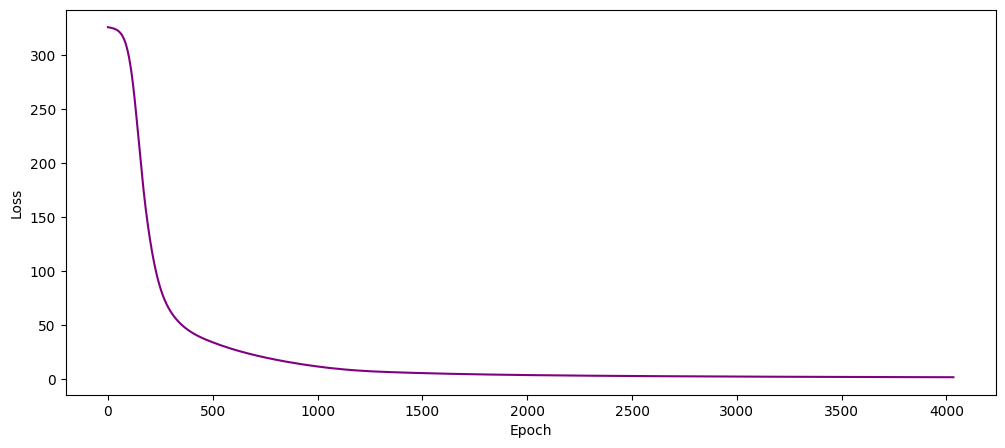

In [45]:
if retrain:
    cmps.train(1,threshold=1e-5,alpha=alpha, beta=beta, update_interval=100)
    embed = GeneEmbedding(vector_file, dataset, vector="average")
    cmps.plot()

In [46]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)

Loading average of 1st and 2nd weights.


100%|██████████| 994/994 [00:00<00:00, 2948471.13it/s]


100%|██████████| 2878624/2878624 [00:03<00:00, 764303.13it/s]


Generating Cell Vectors.


100%|██████████| 2896/2896 [00:00<00:00, 3314.29it/s]

Found 0 Cells with No Counts.
Finished.


In [47]:
adata = cembed.get_adata()
adata

Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 2896 × 994
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes', 'gex_variation', 'louvain_gex', 'clusters_gex', 'louvain_tcr', 'clusters_tcr', 'nndists_gex', 'nndists_tcr', 'is_invariant', 'conga_scores', 'conga_fdr_values'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'entropy'
    uns: 'conga_results', 'conga_stats', 'organism', 'log1p', 'hvg', 'raw_matrix_is_logged', 'pca', 'neighbors', 'umap', 'louvain', 'clusters_tcr_names', 'rank_genes_good_biclusters', 'tcri_clone_key', 'tcri_unique_clonotypes'
    obsm: 'X_pca_tcr', 'X_pca_gex', 'X_umap_gex', 'X_gex_1d', 'X_gex_2d', 'X_umap_tcr', 'X_tcr_1d', 'X_tcr_2d', 'X_genevector', 'X_umap'
    varm: 'PCs'
    layers: 'scaled', 'logcounts'
    obsp: 'distances', 'connectivities'

In [50]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import tqdm
import scanpy as sc
import networkx as nx
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
from scipy.spatial import distance
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
import numpy as np
import operator
import collections
import os   
import pandas as pd
import gc
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

markers = dict()
markers["Naive/CM"] = ["IL7R"]
markers["Activated"] = ["GZMB"]
markers["Memory"] = ["GZMK"]
markers["Dsyfunctional"] = ["TOX"]

def cell_distance(self, vec, norm=True):
    # matrix = self.matrix
    # if norm:
    #     vec /= np.linalg.norm(vec)
    #     print("norm")
    #     matrix = normalize(matrix)
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    odists = []
    for x in tqdm.tqdm(self.adata.obs.index):
        cell_vec = mapped_components[x]
        # if norm:
        #     cell_vec /= np.linalg.norm(cell_vec)
        dist = 1. - distance.cosine(cell_vec, vec)
        odists.append(dist)
    return odists

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

from sklearn import preprocessing

def phenotype_probability(self, adata, phenotype_markers, return_distances=False, method="sparsemax", target_col="genevector", temperature=0.05, normalize=True):
    """
    Probablistically assign phenotypes based on a set of cell type labels and associated markers. 
    Can optionally return the original cosine distances and perform the assignment based on expression weight gene vectors.
    Loads into the anndata the pseudo-probabilities for each cell type and the deterministic label taken from the maximum probability over cell types.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param phenotype_markers: Dictionary of cell type labels (key) to gene markers used to define the cell type as a list (value).
    :type phenotype_markers: dict
    :param return_distances: Change the return type to a tuple that includes a dictionary containing the actual cosine distances alongside the phenotype probabilities.
    :type column: bool
    :param expression_weighted: Compute similarit to each cell using the expression weightedy marker gnene vector.
    :type column: bool
    :param target_col: Column label to load in deterministic cell asssignments in the obs data frame of the anndata object.
    :type target_col: bool
    :return: Anndata with cell type labels and probabilities, or optionally a tuple with the anndata and the raw cosine similarities.
    :rtype:  anndata.AnnData
    """
    if method == "softmax":
        print(bcolors.OKBLUE+"Using **SoftMax**"+bcolors.ENDC)
        pfunc = softmax
    elif method == "sparsemax":
        print(bcolors.OKBLUE+"Using **SparseMax**"+bcolors.ENDC)
        pfunc = self.entmax_15
    elif method == "normalized_exponential":
        print(bcolors.OKBLUE+"Using Normalized Exponential (Temp: {})".format(temperature)+bcolors.ENDC)
        pfunc = lambda x: self.normalized_exponential_vector(x, temperature)
    for x in adata.obs.columns:
        if "Pseudo-probability" in x:
            del adata.obs[x]
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    genes = adata.var.index.to_list()
    cells = adata.obs.index.to_list()
    all_markers = []
    for _, markers in phenotype_markers.items():
        all_markers += markers  
    all_markers = list(set(all_markers))
    probs = dict()

    for pheno, markers in phenotype_markers.items():
        print(bcolors.OKBLUE+"Computing similarities for {}".format(pheno)+bcolors.ENDC)
        print(bcolors.OKGREEN+"Markers: {}".format(", ".join(markers))+bcolors.ENDC)
        vector = self.embed.generate_vector(markers)
        probs[pheno] = cell_distance(self, vector,norm=normalize)
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = np.array(distribution)
    distribution = preprocessing.normalize(distribution)
    distribution = list(zip(*distribution))
    probabilities = []
    for d in distribution:
        p = pfunc(numpy.array(d))
        probabilities.append(p)
    
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    def load_predictions(adata,probs):
        prob_cols = []
        for ph in probs.keys():
            prob_cols.append(ph+" Pseudo-probability")
            adata.obs[ph+" Pseudo-probability"] = probs[ph]
        adata.uns["probability_columns"] = prob_cols
        return adata
    adata = load_predictions(adata, probs)
    if return_distances:
        return adata, res
    else:
        return adata

adata, dist = phenotype_probability(cembed, adata, markers, method="normalized_exponential", temperature=0.0001, return_distances=True, normalize=True)

Using Normalized Exponential (Temp: 0.0001)
Computing similarities for Naive/CM
Markers: IL7R


100%|██████████| 2896/2896 [00:00<00:00, 63867.16it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 2896/2896 [00:00<00:00, 70021.12it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 2896/2896 [00:00<00:00, 70206.08it/s]


Computing similarities for Dsyfunctional
Markers: TOX


100%|██████████| 2896/2896 [00:00<00:00, 70867.17it/s]


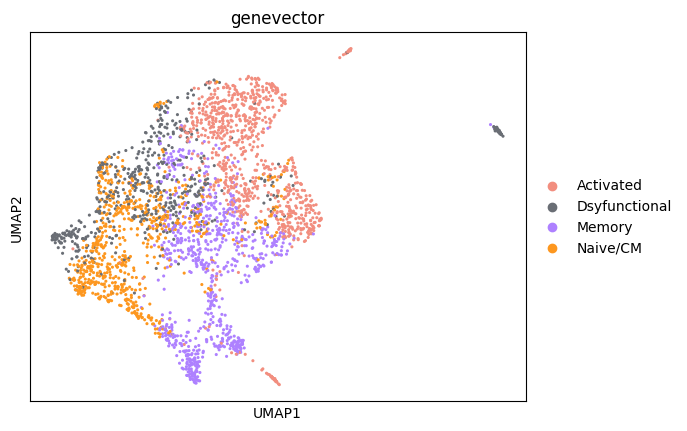

In [55]:
import shutil
sc.pl.umap(adata,color="genevector",s=20,save="pbmc.pdf")

In [59]:

tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(12,4),method="probabilistic",normalized=True,order=["Naive/CM","Memory","Dsyfunctional","Activated"])

KeyError: 'tcri_unique_phenotypes'

In [58]:
adata.obs.columns

Index(['va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b',
       'cdr3b_nucseq', 'n_genes', 'percent_mito', 'n_counts', 'clone_sizes',
       'gex_variation', 'louvain_gex', 'clusters_gex', 'louvain_tcr',
       'clusters_tcr', 'nndists_gex', 'nndists_tcr', 'is_invariant',
       'conga_scores', 'conga_fdr_values', 'clone_size', 'UMAP1', 'UMAP2',
       'log(Clone Size)', 'genevector', 'Naive/CM Pseudo-probability',
       'Activated Pseudo-probability', 'Memory Pseudo-probability',
       'Dsyfunctional Pseudo-probability'],
      dtype='object')